In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

from Model.zoo import UNetModel1024
from Model.Inference import voting_inference, heatmap_inference

from utils import load_image
from utils.model import calculate_iou

2025-07-30 16:42:12.050160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753908132.064134   61119 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753908132.067813   61119 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753908132.077333   61119 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753908132.077348   61119 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753908132.077349   61119 computation_placer.cc:177] computation placer alr

In [2]:
model = UNetModel1024(weights="../../Model/zoo/weights/unet-1024-7030-cbis.weights.h5", input_shape=(128, 128, 1))
model = model.load_model()
output_dir = "../../CBIS"
image_idx = 10
mask_threshold = 0.5
grid_range = (2, 10)
random.seed(42)
index_range = [random.randint(0, 797) for _ in range(50)]

I0000 00:00:1753908134.270832   61119 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4598 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [43]:

image_path = "../../CBIS_DDSM_Dataset/1-014.png"
mask_path = "../../CBIS_DDSM_Dataset/1-015_mask.png"

preds = voting_inference(image_path, (4,10), model, vote_threshold=1, mask_threshold=0, crop_output=128)
heatmap = heatmap_inference(image_path, (4,10), model, crop_output=128)

Grid 4: (16, 128, 128)
Grid 5: (25, 128, 128)
Grid 6: (36, 128, 128)
Grid 7: (49, 128, 128)
Grid 8: (64, 128, 128)
Grid 9: (81, 128, 128)
Grid 10: (100, 128, 128)
Voting statistics:
- Total grids: 7
- Vote threshold: 1
- Pixels with max votes (7): 12723700
- Pixels with >= 1 votes: 12768256
- Final positive pixels: 12768256
Grid 4: (16, 128, 128)
Grid 5: (25, 128, 128)
Grid 6: (36, 128, 128)
Grid 7: (49, 128, 128)
Grid 8: (64, 128, 128)
Grid 9: (81, 128, 128)
Grid 10: (100, 128, 128)


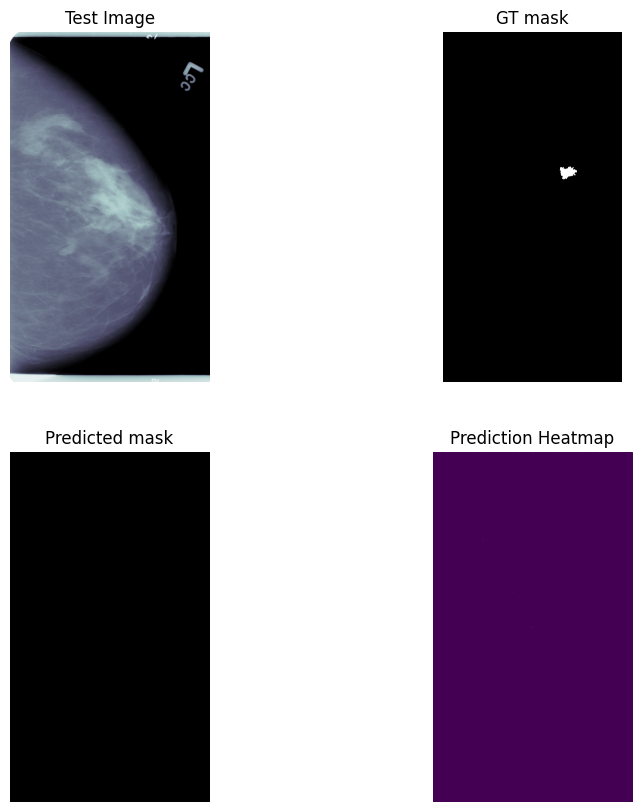

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[1][0].imshow(preds, cmap="gray")
axes[1][0].set_title("Predicted mask")
axes[1][0].axis("off")

im = axes[1][1].imshow(heatmap, cmap='viridis')
axes[1][1].set_title('Prediction Heatmap')
axes[1][1].axis("off")

mask = load_image(mask_path)
axes[0][1].set_title("GT mask")
axes[0][1].imshow(mask, cmap="bone")
axes[0][1].axis("off")

mask = load_image(image_path)
axes[0][0].set_title("Test Image")
axes[0][0].imshow(mask, cmap="bone")
axes[0][0].axis("off")

plt.show()

In [40]:
preds.any()

np.True_

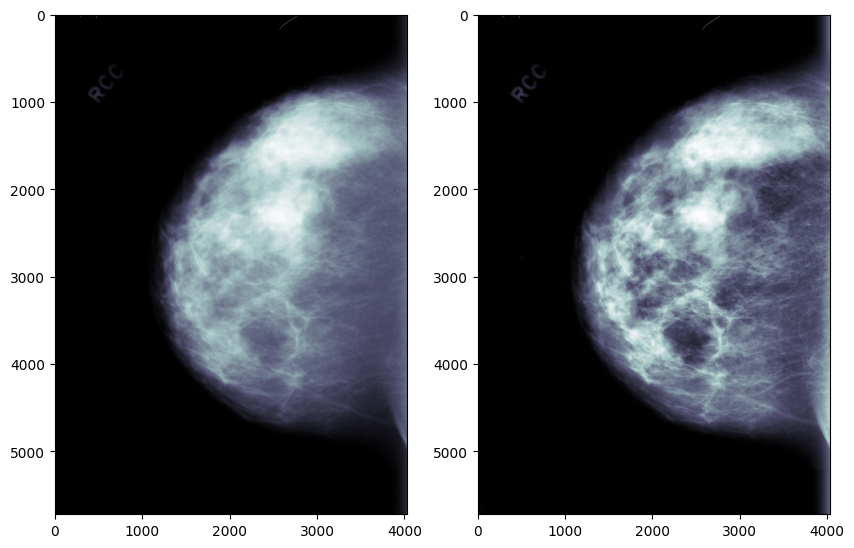

In [18]:
import cv2
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[1].imshow(img_clahe, cmap="bone")
axes[0].imshow(img, cmap="bone")

In [25]:
import cv2
import numpy as np

# Load the preprocessed CLAHE image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img)

# Apply thresholding to segment the muscle (adjust threshold value)
_, thresh = cv2.threshold(img_clahe, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the muscle (adjust based on image orientation)
if contours:
    muscle_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(img_clahe)
    cv2.drawContours(mask, [muscle_contour], -1, 255, thickness=cv2.FILLED)

    # Apply mask to remove muscle
    result = cv2.bitwise_and(img_clahe, img_clahe, mask=mask)